### Denoising fMRI Scans with Diffusion Models:

## Training with Anatomy as Condition

This Code is based on the implementation of the Super-Resolution Network SR3: https://github.com/Janspiry/Image-Super-Resolution-via-Iterative-Refinement.git

Changes were made throughout the full code to convert the super-resolution architecture to a denoising-architecture with an additional condition (Structural MRI / anatomy).
______

Imports

In [ ]:
import torch
import logging
import os
import numpy as np
from torch.utils.data import Dataset
import random
from re import split
import torch.utils.data
from collections import OrderedDict
import functools
from torch.nn import init
from torch.nn import modules

# u-net
import math
import torch.nn.functional as F
from inspect import isfunction

# diffusion
from torch import nn
from functools import partial
from tqdm import tqdm

# learning rate scheduler
import torch.optim.lr_scheduler as lr_scheduler

# mixed precision training for memory
from torch.amp import GradScaler
from torch.amp import autocast

# activation checkpointing
import torch.utils.checkpoint as checkpoint

# read masks
import nibabel as nib
import matplotlib.pyplot as plt

Config

In [ ]:
opt = {
    "name": "denoising",
    "phase": "train",
    "gpu_ids": [0, 1], 
    "debug": False,  
    "enable_wandb": False,  
    "log_wandb_ckpt": False,  
    "log_eval": False,  
    "path": {
        "log": "/kaggle/working/logs",
        "tb_logger": "/kaggle/working/tb_logger",
        "results": "/kaggle/working/results",
        "checkpoint": "/kaggle/working/checkpoint",
        "resume_state": None
    },
    "datasets": {
        "train": {
            "noisy_data_paths": ['/kaggle/input/fmri-train-1-norm-v3/data/noisy_func_train_1.npy',
                '/kaggle/input/fmri-train-2-norm-v3/data/noisy_func_train_2.npy',
                '/kaggle/input/fmri-train-3-norm-v3/data/noisy_func_train_3.npy'],
            "gt_data_paths": ['/kaggle/input/fmri-train-1-norm-v3/data/gt_func_train_1.npy',
                '/kaggle/input/fmri-train-2-norm-v3/data/gt_func_train_2.npy',
                '/kaggle/input/fmri-train-3-norm-v3/data/gt_func_train_3.npy'],
            "mask_data_paths": ['/kaggle/input/coregistered-anatomy/coregistered_outputs/sub-01_smri_coregistered.nii',
                '/kaggle/input/coregistered-anatomy/coregistered_outputs/sub-dd_smri_coregistered.nii',
                '/kaggle/input/coregistered-anatomy/coregistered_outputs/sub-gg_smri_coregistered.nii'],

            "batch_size": 2,
            "num_workers": 4,
            "use_shuffle": True
        },
        "test": {
            "noisy_data_paths": ['/kaggle/input/fmri-test-norm-v3/data/noisy_func_test.npy'],
            "gt_data_paths": ['/kaggle/input/fmri-test/data/gt_func_test.npy'],
            "mask_data_paths": ['/kaggle/input/coregistered-anatomy/coregistered_outputs/sub-uu_smri_coregistered.nii'],
        }
    },
    "model": {
        "which_model_G": "sr3",
        "finetune_norm": False,
        "unet": {
            "in_channel": 3,
            "out_channel": 1,
            "inner_channel": 64,
            "norm_groups": 16,
            "channel_multiplier": [1, 2, 4, 8],
            "attn_res": [8],
            "res_blocks": 1,
            "dropout": 0.1
        },
        "beta_schedule": {
            "train": {
                "schedule": "cosine",
                "n_timestep": 1000,
                "linear_start": 1e-6,
                "linear_end": 1e-2
            },
            "test": {
                "schedule": "cosine",
                "n_timestep": 1000,
                "linear_start": 1e-6,
                "linear_end": 1e-2
            }
        },
        "diffusion": {
            "image_size": 64,
            "channels": 1,
            "conditional": True
        }
    },
    "train": {
        "n_iter": 18000,
        "val_freq": 1e4,
        "save_checkpoint_freq": 1800,
        "print_freq": 100,
        "optimizer": {
            "type": "adam",
            "lr": 5e-5
        },
        "ema_scheduler": {
            "step_start_ema": 1000,
            "update_ema_every": 10,
            "ema_decay": 0.999
        }
    },
    "wandb": {
        "project": "distributed_high_sr_ffhq"
    },
    "config_file": "config/sr_sr3_16_128.json" 
}

In [ ]:
os.makedirs(opt['path']['log'], exist_ok=True)
os.makedirs(opt['path']['tb_logger'], exist_ok=True)
os.makedirs(opt['path']['results'], exist_ok=True)
os.makedirs(opt['path']['checkpoint'], exist_ok=True)

Logger

In [ ]:
# logging
torch.backends.cudnn.enabled = True
torch.backends.cudnn.benchmark = True

def dict2str(opt, indent_l=1):
    '''dict to string for logger'''
    msg = ''
    for k, v in opt.items():
        if isinstance(v, dict):
            msg += ' ' * (indent_l * 2) + k + ':[\n'
            msg += dict2str(v, indent_l + 1)
            msg += ' ' * (indent_l * 2) + ']\n'
        else:
            msg += ' ' * (indent_l * 2) + k + ': ' + str(v) + '\n'
    return msg

def setup_logger(logger_name, root, phase, level=logging.INFO, screen=False):
    '''set up logger'''
    l = logging.getLogger(logger_name)
    formatter = logging.Formatter(
        '%(asctime)s.%(msecs)03d - %(levelname)s: %(message)s', datefmt='%y-%m-%d %H:%M:%S')
    log_file = os.path.join(root, '{}.log'.format(phase))
    fh = logging.FileHandler(log_file, mode='w')
    fh.setFormatter(formatter)
    l.setLevel(level)
    l.addHandler(fh)
    if screen:
        sh = logging.StreamHandler()
        sh.setFormatter(formatter)
        l.addHandler(sh)


setup_logger(None, opt['path']['log'],
                    'train', level=logging.INFO, screen=True)
setup_logger('val', opt['path']['log'], 'val', level=logging.INFO)
logger = logging.getLogger('base')

Dataset creation

In [ ]:
class PairwiseDataset(Dataset):

    def __init__(self, noisy_images_paths: list, gt_images_paths: list, mask_images_paths: list):
        """Initialize fMRI dataset for denoising with memory-efficient loading.
        
        Args:
            noisy_images_paths (list): List of paths to noisy fMRI volumes (.npy files)
            gt_images_paths (list): List of paths to ground truth fMRI volumes (.npy files)
            mask_images_paths (list): List of paths to brain mask volumes (.nii files)
        """
        self.noisy_paths = noisy_images_paths
        self.gt_paths = gt_images_paths
        self.mask_paths = mask_images_paths
        

        self.mask_volumes = [np.rot90(nib.load(path).get_fdata(), k=1, axes=(0, 1)) for path in mask_images_paths]
        
        self.file_slice_mapping = []
        self.z_t_dimension_sizes = []
        total_slices = 0
        dataset_length = 0
        
        for i, path in enumerate(noisy_images_paths):
            data_shape = np.load(path, mmap_mode='r').shape
            num_slices = data_shape[2] * data_shape[3]  # z * t
            self.z_t_dimension_sizes.append((data_shape[2], data_shape[3]))
            
            for batch_idx in range(0, data_shape[3]):
                self.file_slice_mapping.append((i, batch_idx))
                dataset_length += 1
            
            total_slices += num_slices 
            
        self.data_len = dataset_length

    def __len__(self):
        return self.data_len

    def __getitem__(self, index):
        # although named "mask" it refers to the sMRI and deals with it as additional condition
        file_idx, t_idx = self.file_slice_mapping[index]
        
        noisy_file_path = self.noisy_paths[file_idx]
        gt_file_path = self.gt_paths[file_idx]
        
        mask_volume = self.mask_volumes[file_idx]

        noisy_volume = np.load(noisy_file_path, mmap_mode='r')
        gt_volume = np.load(gt_file_path, mmap_mode='r')
        
        noisy_slice = noisy_volume[:, :, :, t_idx].copy()
        gt_slice = gt_volume[:, :, :, t_idx].copy()

        
        return {
            'GT': torch.tensor(gt_slice).float().unsqueeze(0).permute(-1, 0, 1, 2),
            'Noisy': torch.tensor(noisy_slice).float().unsqueeze(0).permute(-1, 0, 1, 2),
            'Mask': torch.tensor(mask_volume.copy()).float().unsqueeze(0).permute(-1, 0, 1, 2),
            'Index': index
        }

In [ ]:
def collate_merge_batches(batch):
    merged = {
        'Noisy': torch.cat([item['Noisy'] for item in batch], dim=0),
        'GT': torch.cat([item['GT'] for item in batch], dim=0),
        'Mask': torch.cat([item['Mask'] for item in batch], dim=0),
        'Index': [item['Index'] for item in batch]
    }
    return merged

def create_dataloader(dataset, dataset_opt, phase):
    '''create dataloader '''
    if phase == 'train':
        return torch.utils.data.DataLoader(
            dataset,
            batch_size=dataset_opt['batch_size'],
            shuffle=dataset_opt['use_shuffle'],
            num_workers=dataset_opt['num_workers'],
            pin_memory=True,
            collate_fn = collate_merge_batches)
    elif phase == 'test':
        return torch.utils.data.DataLoader(
            dataset, batch_size=1, shuffle=False, num_workers=1, pin_memory=True, collate_fn = lambda x: x[0])
    else:
        raise NotImplementedError(
            'Dataloader [{:s}] is not found.'.format(phase))

In [8]:
# Create training dataset and dataloader
train_set = PairwiseDataset(
    opt['datasets']['train']['noisy_data_paths'], 
    opt['datasets']['train']['gt_data_paths'],
    opt['datasets']['train']['mask_data_paths']
)
train_loader = create_dataloader(
    train_set, 
    opt['datasets']['train'], 
    'train'
)
logger.info('Training dataset with {} instances created.'.format(len(train_set)))

# Create testing dataset and dataloader
test_set = PairwiseDataset(
    opt['datasets']['test']['noisy_data_paths'], 
    opt['datasets']['test']['gt_data_paths'],
    opt['datasets']['test']['mask_data_paths']
)
test_loader = create_dataloader(
    test_set, 
    opt['datasets']['test'], 
    'test'
)
logger.info('Test dataset with {} instances created.'.format(len(test_set)))

25-06-23 20:59:53.118 - INFO: Training dataset with 900 instances created.


25-06-23 20:59:53.139 - INFO: Test dataset with 300 instances created.


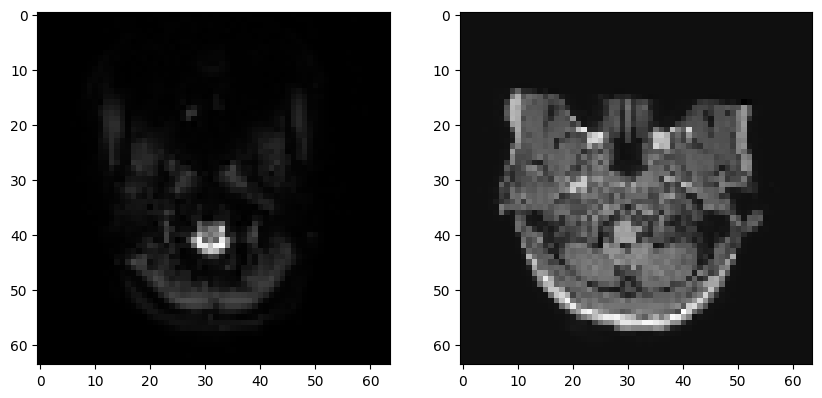

In [ ]:
#example visualization of mask and gt
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

gt_slice = train_set[400]["GT"]
mask_slice = train_set[400]["Mask"]

# Plot ground truth image
axes[0].imshow(gt_slice[0,0,:,:], cmap='gray')
axes[1].imshow(mask_slice[0,0,:,:], cmap='gray')

## Model loading

Modules

In [12]:
# generic functions
def exists(x):
    return x is not None


def default(val, d):
    if exists(val):
        return val
    return d() if isfunction(d) else d


U-Net

In [ ]:
# PositionalEncoding Source： https://github.com/lmnt-com/wavegrad/blob/master/src/wavegrad/model.py
class PositionalEncoding(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, noise_level):
        count = self.dim // 2
        step = torch.arange(count, dtype=noise_level.dtype,
                            device=noise_level.device) / count
        encoding = noise_level.unsqueeze(
            1) * torch.exp(-math.log(1e4) * step.unsqueeze(0))
        encoding = torch.cat(
            [torch.sin(encoding), torch.cos(encoding)], dim=-1)
        return encoding


class FeatureWiseAffine(nn.Module):
    def __init__(self, in_channels, out_channels, use_affine_level=False):
        super(FeatureWiseAffine, self).__init__()
        self.use_affine_level = use_affine_level
        self.noise_func = nn.Sequential(
            nn.Linear(in_channels, out_channels*(1+self.use_affine_level))
        )

    def forward(self, x, noise_embed):
        batch = x.shape[0]
        if self.use_affine_level:
            gamma, beta = self.noise_func(noise_embed).view(
                batch, -1, 1, 1).chunk(2, dim=1)
            x = (1 + gamma) * x + beta
        else:
            x = x + self.noise_func(noise_embed).view(batch, -1, 1, 1)
        return x


class Swish(nn.Module):
    def forward(self, x):
        return x * torch.sigmoid(x)


class Upsample(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.up = nn.Upsample(scale_factor=2, mode="nearest")
        self.conv = nn.Conv2d(dim, dim, 3, padding=1)

    def forward(self, x):
        return self.conv(self.up(x))


class Downsample(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.conv = nn.Conv2d(dim, dim, 3, 2, 1)

    def forward(self, x):
        return self.conv(x)


# building block modules


class Block(nn.Module):
    def __init__(self, dim, dim_out, groups=32, dropout=0):
        super().__init__()
        self.block = nn.Sequential(
            nn.GroupNorm(groups, dim),
            Swish(),
            nn.Dropout(dropout) if dropout != 0 else nn.Identity(),
            nn.Conv2d(dim, dim_out, 3, padding=1)
        )

    def forward(self, x):
        return self.block(x)


class ResnetBlock(nn.Module):
    def __init__(self, dim, dim_out, noise_level_emb_dim=None, dropout=0, use_affine_level=False, norm_groups=32):
        super().__init__()
        self.noise_func = FeatureWiseAffine(
            noise_level_emb_dim, dim_out, use_affine_level)

        self.block1 = Block(dim, dim_out, groups=norm_groups)
        self.block2 = Block(dim_out, dim_out, groups=norm_groups, dropout=dropout)
        self.res_conv = nn.Conv2d(
            dim, dim_out, 1) if dim != dim_out else nn.Identity()

    def forward(self, x, time_emb):
        b, c, h, w = x.shape
        h = self.block1(x)
        h = self.noise_func(h, time_emb)
        h = self.block2(h)
        return h + self.res_conv(x)


class SelfAttention(nn.Module):
    def __init__(self, in_channel, n_head=1, norm_groups=32):
        super().__init__()

        self.n_head = n_head

        self.norm = nn.GroupNorm(norm_groups, in_channel)
        self.qkv = nn.Conv2d(in_channel, in_channel * 3, 1, bias=False)
        self.out = nn.Conv2d(in_channel, in_channel, 1)

    def forward(self, input):
        batch, channel, height, width = input.shape
        n_head = self.n_head
        head_dim = channel // n_head

        norm = self.norm(input)
        qkv = self.qkv(norm).view(batch, n_head, head_dim * 3, height, width)
        query, key, value = qkv.chunk(3, dim=2)  # bhdyx

        attn = torch.einsum(
            "bnchw, bncyx -> bnhwyx", query, key
        ).contiguous() / math.sqrt(channel)
        attn = attn.view(batch, n_head, height, width, -1)
        attn = torch.softmax(attn, -1)
        attn = attn.view(batch, n_head, height, width, height, width)

        out = torch.einsum("bnhwyx, bncyx -> bnchw", attn, value).contiguous()
        out = self.out(out.view(batch, channel, height, width))

        return out + input


class ResnetBlocWithAttn(nn.Module):
    def __init__(self, dim, dim_out, *, noise_level_emb_dim=None, norm_groups=32, dropout=0, with_attn=False):
        super().__init__()
        self.with_attn = with_attn
        self.res_block = ResnetBlock(
            dim, dim_out, noise_level_emb_dim, norm_groups=norm_groups, dropout=dropout)
        if with_attn:
            self.attn = SelfAttention(dim_out, norm_groups=norm_groups)

    def forward(self, x, time_emb):
        x = self.res_block(x, time_emb)
        if(self.with_attn):
            x = self.attn(x)
        return x


class UNet(nn.Module):
    def __init__(
        self,
        in_channel=6,
        out_channel=3,
        inner_channel=32,
        norm_groups=32,
        channel_mults=(1, 2, 4, 8, 8),
        attn_res=(8),
        res_blocks=3,
        dropout=0,
        with_noise_level_emb=True,
        image_size=128
    ):
        super().__init__()

        if with_noise_level_emb:
            noise_level_channel = inner_channel
            self.noise_level_mlp = nn.Sequential(
                PositionalEncoding(inner_channel),
                nn.Linear(inner_channel, inner_channel * 4),
                Swish(),
                nn.Linear(inner_channel * 4, inner_channel)
            )
        else:
            noise_level_channel = None
            self.noise_level_mlp = None

        num_mults = len(channel_mults)
        pre_channel = inner_channel
        feat_channels = [pre_channel]
        now_res = image_size
        downs = [nn.Conv2d(in_channel, inner_channel,
                           kernel_size=3, padding=1)]
        for ind in range(num_mults):
            is_last = (ind == num_mults - 1)
            use_attn = (now_res in attn_res)
            channel_mult = inner_channel * channel_mults[ind]
            for _ in range(0, res_blocks):
                downs.append(ResnetBlocWithAttn(
                    pre_channel, channel_mult, noise_level_emb_dim=noise_level_channel, norm_groups=norm_groups, dropout=dropout, with_attn=use_attn))
                feat_channels.append(channel_mult)
                pre_channel = channel_mult
            if not is_last:
                downs.append(Downsample(pre_channel))
                feat_channels.append(pre_channel)
                now_res = now_res//2
        self.downs = nn.ModuleList(downs)

        self.mid = nn.ModuleList([
            ResnetBlocWithAttn(pre_channel, pre_channel, noise_level_emb_dim=noise_level_channel, norm_groups=norm_groups,
                               dropout=dropout, with_attn=True),
            ResnetBlocWithAttn(pre_channel, pre_channel, noise_level_emb_dim=noise_level_channel, norm_groups=norm_groups,
                               dropout=dropout, with_attn=False)
        ])

        ups = []
        for ind in reversed(range(num_mults)):
            is_last = (ind < 1)
            use_attn = (now_res in attn_res)
            channel_mult = inner_channel * channel_mults[ind]
            for _ in range(0, res_blocks+1):
                ups.append(ResnetBlocWithAttn(
                    pre_channel+feat_channels.pop(), channel_mult, noise_level_emb_dim=noise_level_channel, norm_groups=norm_groups,
                        dropout=dropout, with_attn=use_attn))
                pre_channel = channel_mult
            if not is_last:
                ups.append(Upsample(pre_channel))
                now_res = now_res*2

        self.ups = nn.ModuleList(ups)

        self.final_conv = Block(pre_channel, default(out_channel, in_channel), groups=norm_groups)

    def forward(self, x, time):
        t = self.noise_level_mlp(time) if exists(
            self.noise_level_mlp) else None

        feats = []
    
        
        for layer in self.downs:
            if isinstance(layer, ResnetBlocWithAttn):
                x = checkpoint.checkpoint(layer, x, t, use_reentrant=False) # wrapped memory intensive parts
                #x = layer(x, t)
            else:
                x = layer(x)
            feats.append(x)

        for layer in self.mid:
            if isinstance(layer, ResnetBlocWithAttn):
                x = checkpoint.checkpoint(layer, x, t, use_reentrant=False)
                #x = layer(x, t)
            else:
                x = layer(x)

        for layer in self.ups:
            if isinstance(layer, ResnetBlocWithAttn):
                x = checkpoint.checkpoint(layer, torch.cat((x, feats.pop()), dim=1), t, use_reentrant=False)

            else:
                x = layer(x)

        return self.final_conv(x)

Diffusion

In [ ]:
### Diffusion ###
def _warmup_beta(linear_start, linear_end, n_timestep, warmup_frac):
    betas = linear_end * np.ones(n_timestep, dtype=np.float64)
    warmup_time = int(n_timestep * warmup_frac)
    betas[:warmup_time] = np.linspace(
        linear_start, linear_end, warmup_time, dtype=np.float64)
    return betas


def make_beta_schedule(schedule, n_timestep, linear_start=1e-4, linear_end=2e-2, cosine_s=8e-3):
    if schedule == 'quad':
        betas = np.linspace(linear_start ** 0.5, linear_end ** 0.5,
                            n_timestep, dtype=np.float64) ** 2
    elif schedule == 'linear':
        betas = np.linspace(linear_start, linear_end,
                            n_timestep, dtype=np.float64)
    elif schedule == 'warmup10':
        betas = _warmup_beta(linear_start, linear_end,
                             n_timestep, 0.1)
    elif schedule == 'warmup50':
        betas = _warmup_beta(linear_start, linear_end,
                             n_timestep, 0.5)
    elif schedule == 'const':
        betas = linear_end * np.ones(n_timestep, dtype=np.float64)
    elif schedule == 'jsd':  # 1/T, 1/(T-1), 1/(T-2), ..., 1
        betas = 1. / np.linspace(n_timestep,
                                 1, n_timestep, dtype=np.float64)
    elif schedule == "cosine":
        timesteps = (
            torch.arange(n_timestep + 1, dtype=torch.float64) /
            n_timestep + cosine_s
        )
        alphas = timesteps / (1 + cosine_s) * math.pi / 2
        alphas = torch.cos(alphas).pow(2)
        alphas = alphas / alphas[0]
        betas = 1 - alphas[1:] / alphas[:-1]
        betas = betas.clamp(max=0.999)
    else:
        raise NotImplementedError(schedule)
    return betas


# gaussian diffusion trainer class
class GaussianDiffusion(nn.Module):
    def __init__(
        self,
        denoise_fn,
        image_size,
        channels=3,
        loss_type='l1',
        conditional=True,
        schedule_opt=None
    ):
        super().__init__()
        self.channels = channels
        self.image_size = image_size
        self.denoise_fn = denoise_fn
        self.loss_type = loss_type
        self.conditional = conditional
        if schedule_opt is not None:
            pass

    def set_loss(self, device):
        if self.loss_type == 'l1':
            self.loss_func = nn.L1Loss(reduction='sum').to(device)
        elif self.loss_type == 'l2':
            self.loss_func = nn.MSELoss(reduction='sum').to(device)
        else:
            raise NotImplementedError()

    def set_new_noise_schedule(self, schedule_opt, device):
        to_torch = partial(torch.tensor, dtype=torch.float32, device=device)

        betas = make_beta_schedule(
            schedule=schedule_opt['schedule'],
            n_timestep=schedule_opt['n_timestep'],
            linear_start=schedule_opt['linear_start'],
            linear_end=schedule_opt['linear_end'])
        betas = betas.detach().cpu().numpy() if isinstance(
            betas, torch.Tensor) else betas
        alphas = 1. - betas
        alphas_cumprod = np.cumprod(alphas, axis=0)
        alphas_cumprod_prev = np.append(1., alphas_cumprod[:-1])
        self.sqrt_alphas_cumprod_prev = np.sqrt(
            np.append(1., alphas_cumprod))

        timesteps, = betas.shape
        self.num_timesteps = int(timesteps)
        self.register_buffer('betas', to_torch(betas))
        self.register_buffer('alphas_cumprod', to_torch(alphas_cumprod))
        self.register_buffer('alphas_cumprod_prev',
                             to_torch(alphas_cumprod_prev))

        # calculations for diffusion q(x_t | x_{t-1}) and others
        self.register_buffer('sqrt_alphas_cumprod',
                             to_torch(np.sqrt(alphas_cumprod)))
        self.register_buffer('sqrt_one_minus_alphas_cumprod',
                             to_torch(np.sqrt(1. - alphas_cumprod)))
        self.register_buffer('log_one_minus_alphas_cumprod',
                             to_torch(np.log(1. - alphas_cumprod)))
        self.register_buffer('sqrt_recip_alphas_cumprod',
                             to_torch(np.sqrt(1. / alphas_cumprod)))
        self.register_buffer('sqrt_recipm1_alphas_cumprod',
                             to_torch(np.sqrt(1. / alphas_cumprod - 1)))

        # calculations for posterior q(x_{t-1} | x_t, x_0)
        posterior_variance = betas * \
            (1. - alphas_cumprod_prev) / (1. - alphas_cumprod)
        self.register_buffer('posterior_variance',
                             to_torch(posterior_variance))
        self.register_buffer('posterior_log_variance_clipped', to_torch(
            np.log(np.maximum(posterior_variance, 1e-20))))
        self.register_buffer('posterior_mean_coef1', to_torch(
            betas * np.sqrt(alphas_cumprod_prev) / (1. - alphas_cumprod)))
        self.register_buffer('posterior_mean_coef2', to_torch(
            (1. - alphas_cumprod_prev) * np.sqrt(alphas) / (1. - alphas_cumprod)))

    def predict_start_from_noise(self, x_t, t, noise):
        return self.sqrt_recip_alphas_cumprod[t] * x_t - \
            self.sqrt_recipm1_alphas_cumprod[t] * noise

    def q_posterior(self, x_start, x_t, t):
        posterior_mean = self.posterior_mean_coef1[t] * \
            x_start + self.posterior_mean_coef2[t] * x_t
        posterior_log_variance_clipped = self.posterior_log_variance_clipped[t]
        return posterior_mean, posterior_log_variance_clipped

    def p_mean_variance(self, x, t, clip_denoised: bool, condition_x=None, mask=None):
        batch_size = x.shape[0]
        noise_level = torch.tensor(
            [self.sqrt_alphas_cumprod_prev[t+1]], dtype=torch.float32).repeat(batch_size, 1).to(x.device)
        if condition_x is not None:
            if condition_x.shape[0] != mask.shape[0]:
                repeats = condition_x.shape[0] // mask.shape[0]
                mask = mask.repeat(repeats, 1, 1, 1)

            denoise_input = torch.cat([condition_x, mask, x], dim=1)
            x_recon = self.predict_start_from_noise(
                x, t=t, noise=self.denoise_fn(denoise_input, noise_level))
        else:
            x_recon = self.predict_start_from_noise(
                x, t=t, noise=self.denoise_fn(x, noise_level))

        if clip_denoised:
            x_recon.clamp_(-1., 1.)

        model_mean, posterior_log_variance = self.q_posterior(
            x_start=x_recon, x_t=x, t=t)
        return model_mean, posterior_log_variance

    @torch.no_grad()
    def p_sample(self, x, t, clip_denoised=True, condition_x=None, mask=None):
        model_mean, model_log_variance = self.p_mean_variance(
            x=x, t=t, clip_denoised=clip_denoised, condition_x=condition_x, mask=mask)
        noise = torch.randn_like(x) if t > 0 else torch.zeros_like(x)
        return model_mean + noise * (0.5 * model_log_variance).exp()

    @torch.no_grad()
    def p_sample_loop(self, x_in, mask, continous=False):
        device = self.betas.device
        sample_inter = (1 | (self.num_timesteps//10))
        if not self.conditional:
            shape = x_in
            img = torch.randn(shape, device=device)
            ret_img = img
            for i in tqdm(reversed(range(0, self.num_timesteps)), desc='sampling loop time step', total=self.num_timesteps):
                img = self.p_sample(img, i)
                if i % sample_inter == 0:
                    ret_img = torch.cat([ret_img, img], dim=0)
        else:
            x = x_in
            shape = x.shape
            img = torch.randn(shape, device=device)
            ret_img = x
            for i in tqdm(reversed(range(0, self.num_timesteps)), desc='sampling loop time step', total=self.num_timesteps):
                img = self.p_sample(img, i, condition_x=x, mask=mask)
                if i % sample_inter == 0:
                    ret_img = torch.cat([ret_img, img], dim=0)
        if continous:
            return ret_img
        else:
            return ret_img[-1]

    @torch.no_grad()
    def sample(self, batch_size=1, continous=False):
        image_size = self.image_size
        channels = self.channels
        return self.p_sample_loop((batch_size, channels, image_size, image_size), continous)

    @torch.no_grad()
    def super_resolution(self, x_in, mask, continous=False):
        return self.p_sample_loop(x_in, mask, continous)

    def q_sample(self, x_start, continuous_sqrt_alpha_cumprod, noise=None):
        noise = default(noise, lambda: torch.randn_like(x_start))
        return (
            continuous_sqrt_alpha_cumprod * x_start +
            (1 - continuous_sqrt_alpha_cumprod**2).sqrt() * noise
        )

    def p_losses(self, x_in, noise=None):
        x_start = x_in['GT']
        noisy_input = x_in['Noisy']
        mask_input = x_in['Mask']
        

        if noisy_input.shape[0] != mask_input.shape[0]:
            repeats = noisy_input.shape[0] // mask_input.shape[0]
            mask_input = mask_input.repeat(repeats, 1, 1, 1)

        [b, c, h, w] = x_start.shape
        t = np.random.randint(1, self.num_timesteps + 1)
        continuous_sqrt_alpha_cumprod = torch.tensor(
            np.random.uniform(
                self.sqrt_alphas_cumprod_prev[t-1],
                self.sqrt_alphas_cumprod_prev[t],
                size=b
            ),
            dtype=torch.float32
        ).to(x_start.device)
        continuous_sqrt_alpha_cumprod = continuous_sqrt_alpha_cumprod.view(b, -1)

        noise = default(noise, lambda: torch.randn_like(x_start))
        x_noisy = self.q_sample(
            x_start=x_start, continuous_sqrt_alpha_cumprod=continuous_sqrt_alpha_cumprod.view(-1, 1, 1, 1), noise=noise)

        if not self.conditional:
            x_recon = self.denoise_fn(x_noisy, continuous_sqrt_alpha_cumprod)
        else:
            x_recon = self.denoise_fn(
                torch.cat([noisy_input, mask_input, x_noisy], dim=1), continuous_sqrt_alpha_cumprod)

        loss = self.loss_func(noise, x_recon)
        return loss

    def forward(self, x, *args, **kwargs):
        return self.p_losses(x, *args, **kwargs)

Helper functions

In [ ]:
def weights_init_normal(m, std=0.02):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        init.normal_(m.weight.data, 0.0, std)
        if m.bias is not None:
            m.bias.data.zero_()
    elif classname.find('Linear') != -1:
        init.normal_(m.weight.data, 0.0, std)
        if m.bias is not None:
            m.bias.data.zero_()
    elif classname.find('BatchNorm2d') != -1:
        init.normal_(m.weight.data, 1.0, std)  # BN also uses norm
        init.constant_(m.bias.data, 0.0)


def weights_init_kaiming(m, scale=1):
    classname = m.__class__.__name__
    if classname.find('Conv2d') != -1:
        init.kaiming_normal_(m.weight.data, a=0, mode='fan_in')
        m.weight.data *= scale
        if m.bias is not None:
            m.bias.data.zero_()
    elif classname.find('Linear') != -1:
        init.kaiming_normal_(m.weight.data, a=0, mode='fan_in')
        m.weight.data *= scale
        if m.bias is not None:
            m.bias.data.zero_()
    elif classname.find('BatchNorm2d') != -1:
        init.constant_(m.weight.data, 1.0)
        init.constant_(m.bias.data, 0.0)


def weights_init_orthogonal(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        init.orthogonal_(m.weight.data, gain=1)
        if m.bias is not None:
            m.bias.data.zero_()
    elif classname.find('Linear') != -1:
        init.orthogonal_(m.weight.data, gain=1)
        if m.bias is not None:
            m.bias.data.zero_()
    elif classname.find('BatchNorm2d') != -1:
        init.constant_(m.weight.data, 1.0)
        init.constant_(m.bias.data, 0.0)


def init_weights(net, init_type='kaiming', scale=1, std=0.02):
    # scale for 'kaiming', std for 'normal'.
    logger.info('Initialization method [{:s}]'.format(init_type))
    if init_type == 'normal':
        weights_init_normal_ = functools.partial(weights_init_normal, std=std)
        net.apply(weights_init_normal_)
    elif init_type == 'kaiming':
        weights_init_kaiming_ = functools.partial(
            weights_init_kaiming, scale=scale)
        net.apply(weights_init_kaiming_)
    elif init_type == 'orthogonal':
        net.apply(weights_init_orthogonal)
    else:
        raise NotImplementedError(
            'initialization method [{:s}] not implemented'.format(init_type))

Network Definition

In [ ]:
# Generator
def define_G(opt):
    model_opt = opt['model']
    if ('norm_groups' not in model_opt['unet']) or model_opt['unet']['norm_groups'] is None:
        model_opt['unet']['norm_groups']=32
    model = UNet(
        in_channel=model_opt['unet']['in_channel'],
        out_channel=model_opt['unet']['out_channel'],
        norm_groups=model_opt['unet']['norm_groups'],
        inner_channel=model_opt['unet']['inner_channel'],
        channel_mults=model_opt['unet']['channel_multiplier'],
        attn_res=model_opt['unet']['attn_res'],
        res_blocks=model_opt['unet']['res_blocks'],
        dropout=model_opt['unet']['dropout'],
        image_size=model_opt['diffusion']['image_size']
    )
    netG = GaussianDiffusion(
        model,
        image_size=model_opt['diffusion']['image_size'],
        channels=model_opt['diffusion']['channels'],
        loss_type='l2',    # L1 or L2
        conditional=model_opt['diffusion']['conditional'],
        schedule_opt=model_opt['beta_schedule']['train']
    )
    if opt['phase'] == 'train':
        # init_weights(netG, init_type='kaiming', scale=0.1)
        init_weights(netG, init_type='orthogonal')
    if opt['gpu_ids']:
        assert torch.cuda.is_available()
    return netG

Model classes

In [ ]:
class SR3():
    def __init__(self, opt):       
        self.opt = opt
        self.device = torch.device(
            'cuda' if opt['gpu_ids'] is not None else 'cpu')

        # mixed precision training
        self.scaler = GradScaler()
        
        self.begin_step = 0
        self.begin_epoch = 0

        # define network and load pretrained models
        self.netG = self.set_device(define_G(opt))
        self.schedule_phase = None
        

        # set loss and load resume state
        self.set_loss()
        self.set_new_noise_schedule(
            opt['model']['beta_schedule']['train'], schedule_phase='train')
        if self.opt['phase'] == 'train':
            self.netG.train()
            if opt['model']['finetune_norm']:
                optim_params = []
                for k, v in self.netG.named_parameters():
                    v.requires_grad = False
                    if k.find('transformer') >= 0:
                        v.requires_grad = True
                        v.data.zero_()
                        optim_params.append(v)
                        logger.info(
                            'Params [{:s}] initialized to 0 and will optimize.'.format(k))
            else:
                optim_params = list(self.netG.parameters())

            self.optG = torch.optim.Adam(
                optim_params, lr=opt['train']["optimizer"]["lr"],
                weight_decay=1e-6)

            #learning rate scheduler
            self.schedulerG = lr_scheduler.CosineAnnealingLR(
                self.optG, T_max=self.opt['train']['n_iter'], eta_min=1e-6)
            
            self.log_dict = OrderedDict()
        self.load_network()
        self.print_network()

    def set_device(self, x):
        if isinstance(x, dict):
            for key, item in x.items():
                if item is not None and type(item)==torch.Tensor:
                    x[key] = item.to(self.device)
        elif isinstance(x, list):
            for item in x:
                if item is not None:
                    item = item.to(self.device)
        else:
            x = x.to(self.device)
        return x

    def get_network_description(self, network):
        '''Get the string and total parameters of the network'''
        if isinstance(network, nn.DataParallel):
            network = network.module
        s = str(network)
        n = sum(map(lambda x: x.numel(), network.parameters()))
        return s, n

    def feed_data(self, data):
        self.data = self.set_device(data)

    def optimize_parameters(self):
        self.optG.zero_grad()

        # mixed precision
        with torch.cuda.amp.autocast(): 
            l_pix = self.netG(self.data)
            b, c, h, w = self.data['GT'].shape
            l_pix = l_pix.sum()/int(b*c*h*w)

        self.scaler.scale(l_pix).backward()

        self.scaler.unscale_(self.optG)
        torch.nn.utils.clip_grad_norm_(self.netG.parameters(), max_norm=0.5)

        self.scaler.step(self.optG)
        self.scaler.update()  

        #scheduler step
        self.schedulerG.step()

        # set log
        self.log_dict['l_pix'] = l_pix.item()

        return l_pix.item()

    def evaluate_loss(self, data):
        """
        Calculates the diffusion loss for a given batch of data without training.
        Sets model to eval mode and uses torch.no_grad() for efficiency.
        """
        self.netG.eval()
        with torch.no_grad():
            self.feed_data(data)

            with torch.cuda.amp.autocast():
                l_pix = self.netG(self.data)
                b, c, h, w = self.data['GT'].shape
                l_pix = l_pix.sum() / int(b * c * h * w)
        self.netG.train() 
        return l_pix.item()
    
    def test(self, continous=False):
        self.netG.eval()
        with torch.no_grad():
            noisy_input = self.data['Noisy']
            mask_input = self.data['Mask']
            
            if isinstance(self.netG, nn.DataParallel):
                self.SR = self.netG.module.super_resolution(
                    noisy_input, mask_input, continous)
            else:
                self.SR = self.netG.super_resolution(
                    noisy_input, mask_input, continous)
        self.netG.train()

    def sample(self, batch_size=1, continous=False):
        self.netG.eval()
        with torch.no_grad():
            if isinstance(self.netG, nn.DataParallel):
                self.SR = self.netG.module.sample(batch_size, continous)
            else:
                self.SR = self.netG.sample(batch_size, continous)
        self.netG.train()

    def set_loss(self):
        if isinstance(self.netG, nn.DataParallel):
            self.netG.module.set_loss(self.device)
        else:
            self.netG.set_loss(self.device)

    def set_new_noise_schedule(self, schedule_opt, schedule_phase='train'):
        if self.schedule_phase is None or self.schedule_phase != schedule_phase:
            self.schedule_phase = schedule_phase
            if isinstance(self.netG, nn.DataParallel):
                self.netG.module.set_new_noise_schedule(
                    schedule_opt, self.device)
            else:
                self.netG.set_new_noise_schedule(schedule_opt, self.device)

    def get_current_log(self):
        return self.log_dict

    def get_current_visuals(self, need_LR=True, sample=False):
        out_dict = OrderedDict()
        if sample:
            out_dict['SAM'] = self.SR.detach().float().cpu()
        else:
            out_dict['SR'] = self.SR.detach().float().cpu()
            out_dict['Noisy'] = self.data['Noisy'].detach().float().cpu()
            out_dict['GT'] = self.data['GT'].detach().float().cpu()
        return out_dict

    def print_network(self):
        s, n = self.get_network_description(self.netG)
        if isinstance(self.netG, nn.DataParallel):
            net_struc_str = '{} - {}'.format(self.netG.__class__.__name__,
                                             self.netG.module.__class__.__name__)
        else:
            net_struc_str = '{}'.format(self.netG.__class__.__name__)

        logger.info(
            'Network G structure: {}, with parameters: {:,d}'.format(net_struc_str, n))
        logger.info(s)

    def save_network(self, epoch, iter_step, is_final=False):
        if is_final:
            gen_path = os.path.join(
                self.opt['path']['checkpoint'], 'Final_I{}_E{}_gen.pth'.format(iter_step, epoch))
            opt_path = os.path.join(
                self.opt['path']['checkpoint'], 'Final_I{}_E{}_opt.pth'.format(iter_step, epoch))
        else:
            gen_path = os.path.join(
                self.opt['path']['checkpoint'], 'I{}_E{}_gen.pth'.format(iter_step, epoch))
            opt_path = os.path.join(
                self.opt['path']['checkpoint'], 'I{}_E{}_opt.pth'.format(iter_step, epoch))
        # gen
        network = self.netG
        if isinstance(self.netG, nn.DataParallel):
            network = network.module
        state_dict = network.state_dict()
        for key, param in state_dict.items():
            state_dict[key] = param.cpu()
        torch.save(state_dict, gen_path)
        # opt
        opt_state = {'epoch': epoch, 'iter': iter_step,
                     'scheduler': None, 'optimizer': None}
        opt_state['optimizer'] = self.optG.state_dict()
        torch.save(opt_state, opt_path)

        logger.info(
            'Saved model in [{:s}] ...'.format(gen_path))

    def load_network(self):
        load_path = self.opt['path']['resume_state']
        if load_path is not None:
            logger.info(
                'Loading pretrained model for G [{:s}] ...'.format(load_path))
            gen_path = '{}_gen.pth'.format(load_path)
            opt_path = '{}_opt.pth'.format(load_path)
            network = self.netG

            if isinstance(self.netG, nn.DataParallel):
                network = network.module
            network.load_state_dict(torch.load(
                gen_path), strict=(not self.opt['model']['finetune_norm']))
            
            if self.opt['phase'] == 'train':

                opt = torch.load(opt_path)
                self.optG.load_state_dict(opt['optimizer'])
                self.begin_step = opt['iter']
                self.begin_epoch = opt['epoch']

Training process

In [ ]:
# model
diffusion = SR3(opt)

# Train
epoch_loss_list = []

current_step = diffusion.begin_step
current_epoch = diffusion.begin_epoch
n_iter = opt['train']['n_iter']

if opt['path']['resume_state']:
    logger.info('Resuming training from epoch: {}, iter: {}.'.format(
        current_epoch, current_step))

diffusion.set_new_noise_schedule(
    opt['model']['beta_schedule'][opt['phase']], schedule_phase=opt['phase'])


if opt['phase'] == 'train':
    while current_step < n_iter:
        current_epoch += 1
        epoch_loss_values = []

        # Reset gradients at the beginning of each epoch
        diffusion.optG.zero_grad() 
        
        for _, train_data in enumerate(train_loader): 
            current_step += 1
            if current_step > n_iter:
                break
            diffusion.feed_data(train_data)

            current_l_pix = diffusion.optimize_parameters()
            epoch_loss_values.append(current_l_pix)
                
            # log
            if current_step % opt['train']['print_freq'] == 0:
                logs = diffusion.get_current_log()
                message = '<epoch:{:3d}, iter:{:8,d}> '.format(
                    current_epoch, current_step)
                for k, v in logs.items():
                    message += '{:s}: {:.4e} '.format(k, v)
                logger.info(message)
                
            if current_step % opt['train']['save_checkpoint_freq'] == 0:
                logger.info('Saving models and training states.')
                diffusion.save_network(current_epoch, current_step)
            
            if current_step == n_iter:
                logger.info("Saving final model")
                diffusion.save_network(current_epoch, current_step, is_final=True)


        epoch_loss = sum(epoch_loss_values)/len(epoch_loss_values)
        print('Epoch Loss: ', epoch_loss)
        epoch_loss_list.append(epoch_loss)

    # save model
    print('Epoch Loss List: ', epoch_loss_list)
    logger.info('End of training.')


/tmp/ipykernel_19/3055643826.py:78: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(): # <--- Add this context manager


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:227: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(


25-06-23 21:05:11.331 - INFO: <epoch:  1, iter:     100> l_pix: inf 


25-06-23 21:08:12.537 - INFO: <epoch:  1, iter:     200> l_pix: inf 


25-06-23 21:11:13.739 - INFO: <epoch:  1, iter:     300> l_pix: inf 


25-06-23 21:14:14.950 - INFO: <epoch:  1, iter:     400> l_pix: inf 


#### Training visualization

In [ ]:
def save_loss_curve(epoch_loss_list, filename='loss_curve.png'):
    epochs = range(1, len(epoch_loss_list) + 1)  # X-axis starts at 1
    plt.figure(figsize=(8, 5))
    plt.plot(epochs, epoch_loss_list, marker='o', label='Training Loss')
    plt.title('Loss Curve')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.xticks(epochs)  # Set integer ticks
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.savefig(filename)
    plt.close()

In [ ]:
save_loss_curve(epoch_loss_list, "/kaggle/working/train_loss.png")